# pyslammer demo: batch simulations
This notebook shows an example use case of pyslammer for running batch simulations.
## Setup

Assumes pyslammer is installed in the current python environment. 
*Documentation on installation pending*

First, import pyslammer using:

```python
import pyslammer as slam
```

Additional Python libraries, such as `matplotlib` may also be useful.

In [1]:
# If running in Jupyterlite with Pyodide, install the additional packages
# %pip install pyslammer
# %pip install ipywidgets
# %pip install numpy
# %pip install sympy
# %pip install scipy
# %pip install matplotlib
# %pip install ipympl
%matplotlib widget

In [2]:
# If running on a local machine with the full pyslammer repository, just add the parent directory to the path
import sys
sys.path.append('..')

In [3]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
kys = np.linspace(0.1,0.7,7)
histories = slam.sample_ground_motions()
output = {}

# Batch Simulations
The code below evaluates all combinations of $k_y$ contained in `kys` and every motion in `histories`.
Some key features (motion, ky, max displacement, and displacement time histories) are stored in a dictionary, which 
is then converted to a pandas dataframe.

In [5]:
run = 0

# additional terms needed for dynamic analysis:
height = 50.0
vs_slope = 600.0
vs_base = 600.0
damp_ratio = 0.05
ref_strain = 0.0005
scale_factor = 1.0
soil_model = "equivalent_linear"#"linear_elastic"#


for ky in kys:
    for vs in [200, 400, 600, 800, 1000]:
        for motion, hist in histories.items():
            # create dictionary of input parameters for rigid block analysis
            rigid_inputs = {
                "a_in": hist.accel,
                "dt": hist.dt,
                "ky": ky
            }
            dynamic_inputs = {
                "height": height,
                "vs_slope": vs,
                "vs_base": vs_base,
                "damp_ratio": damp_ratio,
                "ref_strain": ref_strain,
                "scale_factor": scale_factor,
                "soil_model": soil_model
            }
            common_params = {
                "motion": motion,
                "Tm": hist.mean_period,
                "kmax": hist.pga,
                "ky/kmax": ky/hist.pga,
                "Ts/Tm": (4*height/vs)/hist.mean_period
            }
            rigid_result = slam.RigidAnalysis(**rigid_inputs)
            decoupled_result = slam.Decoupled(**rigid_inputs, **dynamic_inputs)
            coupled_result = slam.Coupled(**rigid_inputs, **dynamic_inputs)
    
            output[run] = {**common_params,"method":"rigid", "ky":ky, "d_max": rigid_result.max_sliding_disp, 
                           "diff_rigid":0}
            output[run+1] = {**common_params,"method":"decoupled", "ky":ky, "d_max": decoupled_result.max_sliding_disp, 
                             "diff_rigid":rigid_result.max_sliding_disp-decoupled_result.max_sliding_disp}
            output[run+2] = {**common_params,"method":"coupled", "ky":ky, "d_max": coupled_result.max_sliding_disp, 
                             "diff_rigid":rigid_result.max_sliding_disp-coupled_result.max_sliding_disp}
            run += 3

In [6]:
run

1890

In [7]:
# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output,orient='index')


In [49]:
df

,motion,Tm,kmax,ky/kmax,Ts/Tm,method,ky,d_max,diff_rigid,tsm_bin,kym_bin
0,Morgan_Hill_1984_CYC-285,0.549611,1.298170,0.077032,1.819468,rigid,0.1,3.586510e-01,0.000000e+00,2.0,0.1
1,Morgan_Hill_1984_CYC-285,0.549611,1.298170,0.077032,1.819468,decoupled,0.1,7.944142e-03,3.507068e-01,2.0,0.1
2,Morgan_Hill_1984_CYC-285,0.549611,1.298170,0.077032,1.819468,coupled,0.1,5.180189e-03,3.534708e-01,2.0,0.1
3,Nisqually_2001_UNR-058,0.689081,0.274017,0.364941,1.451208,rigid,0.1,4.090052e-02,0.000000e+00,1.5,0.4
4,Nisqually_2001_UNR-058,0.689081,0.274017,0.364941,1.451208,decoupled,0.1,0.000000e+00,4.090052e-02,1.5,0.4
...,...,...,...,...,...,...,...,...,...,...,...
1885,Kobe_1995_TAK-090,0.990348,0.615515,1.137259,0.201949,decoupled,0.7,3.926440e-03,-3.926440e-03,0.5,1.1
1886,Kobe_1995_TAK-090,0.990348,0.615515,1.137259,0.201949,coupled,0.7,3.695440e-04,-3.695440e-04,0.5,1.1
1887,Coyote_Lake_1979_G02-050,0.367324,0.210928,3.318668,0.544478,rigid,0.7,2.290104e-17,0.000000e+00,0.5,1.2
1888,Coyote_Lake_1979_G02-050,0.367324,0.210928,3.318668,0.544478,decoupled,0.7,0.000000e+00,2.290104e-17,0.5,1.2


In [48]:
tsm_bins = np.linspace(0.5, 4, 8)
kym_bins = np.linspace(0.1,1.2,12)
# Function to find the closest bin
def find_closest_bin(value, bins):
    return bins[np.abs(bins - value).argmin()]

# Apply the function to create the new column
df["tsm_bin"] = df["Ts/Tm"].apply(lambda x: find_closest_bin(x, tsm_bins))
df["kym_bin"] = df["ky/kmax"].apply(lambda x: find_closest_bin(x, kym_bins))

## Comparing multiple motions
The results of the analyses can be plotted to show trends in total accumulated displacement with $k_y$ for each ground motion in the sample ground motion suite.

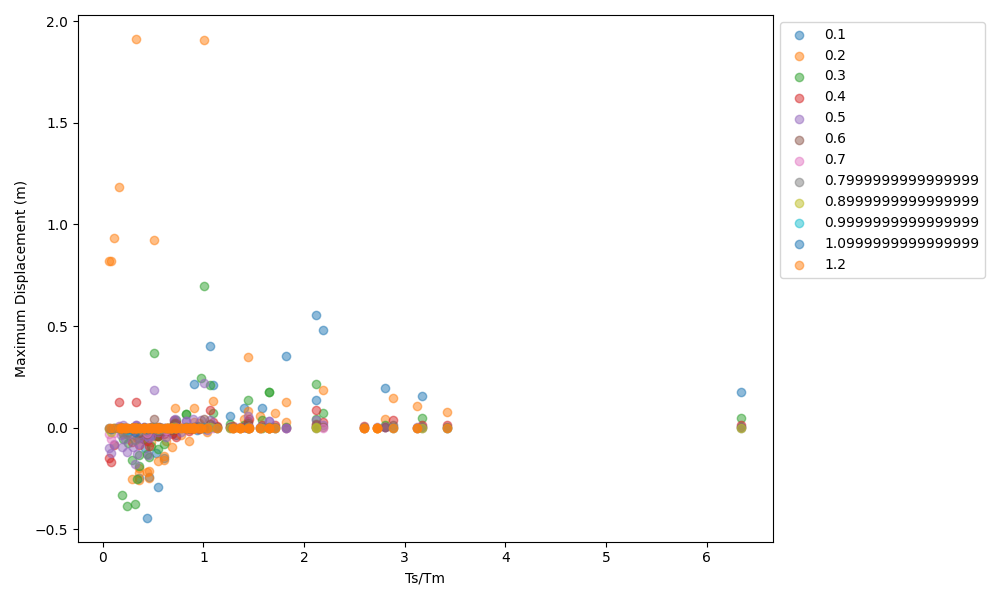

In [58]:
plt.close('all')
target = 0.3
range = 0.1
# df_plot = df[abs(df["tsm_bin"]-target)<range]
df_plot = df[df["method"]=="coupled"]
# df_plot =  df
fig, ax = plt.subplots()
fig.set_size_inches(10,6)   
for key, grp in df_plot.groupby(['kym_bin']):
    ax.scatter(grp["Ts/Tm"], grp["diff_rigid"], label=key[0], alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_yscale('log')
# ax.set_ylim(-2,2)
# ax.set_xlim(0,1)
ax.set_xlabel('Ts/Tm')
ax.set_ylabel('Maximum Displacement (m)')
# ax.set_title('Maximum Displacement vs. Yield Acceleration')

plt.tight_layout()
plt.show()